In [1]:
import numpy as np
from datetime import datetime
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import datasets, transforms

import matplotlib.pyplot as plt

# check device
print(torch.cuda.is_available())
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

True


In [2]:
%config InlineBackend.figure_format = 'retina'

In [3]:
# parameters
RANDOM_SEED = 42
LEARNING_RATE = 0.001
BATCH_SIZE = 32
N_EPOCHS = 15

IMG_SIZE = 32
N_CLASSES = 10

In [4]:
def get_accuracy(model, data_loader, device):
    '''
    Function for computing the accuracy of the predictions over the entire data_loader
    '''

    correct_pred = 0
    n = 0

    with torch.no_grad():
        model.eval()
        for X, y_true in data_loader:
            X = X.to(device)
            y_true = y_true.to(device)

            _, y_prob = model(X)
            _, predicted_labels = torch.max(y_prob, 1)

            n += y_true.size(0)
            correct_pred += (predicted_labels == y_true).sum()

    return correct_pred.float() / n


def plot_losses(train_losses, valid_losses):
    '''
    Function for plotting training and validation losses
    '''

    # temporarily change the style of the plots to seaborn
    plt.style.use('seaborn')

    train_losses = np.array(train_losses)
    valid_losses = np.array(valid_losses)

    fig, ax = plt.subplots(figsize=(8, 4.5))

    ax.plot(train_losses, color='blue', label='Training loss')
    ax.plot(valid_losses, color='red', label='Validation loss')
    ax.set(title="Loss over epochs",
           xlabel='Epoch',
           ylabel='Loss')
    ax.legend()
    fig.show()

    # change the plot style to default

    plt.style.use('default')
    plt.ylim([0, 0.25])


def train(train_loader, model, criterion, optimizer, device):
    '''
    Function for the training step of the training loop
    '''

    model.train()
    running_loss = 0

    for X, y_true in train_loader:
        optimizer.zero_grad()

        X = X.to(device)
        y_true = y_true.to(device)

        # Forward pass
        y_hat, _ = model(X)
        loss = criterion(y_hat, y_true)
        running_loss += loss.item() * X.size(0)

        # Backward pass
        loss.backward()
        optimizer.step()

    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss


def validate(valid_loader, model, criterion, device):
    '''
    Function for the validation step of the training loop
    '''

    model.eval()
    running_loss = 0

    for X, y_true in valid_loader:
        X = X.to(device)
        y_true = y_true.to(device)

        # Forward pass and record loss
        y_hat, _ = model(X)
        loss = criterion(y_hat, y_true)
        running_loss += loss.item() * X.size(0)

    epoch_loss = running_loss / len(valid_loader.dataset)

    return model, epoch_loss


def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device, print_every=1):
    '''
    Function defining the entire training loop
    '''

    # set objects for storing metrics
    best_loss = 1e10
    train_losses = []
    valid_losses = []

    # Train model
    for epoch in range(0, epochs):

        # training
        model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, device)
        train_losses.append(train_loss)

        # validation
        with torch.no_grad(): # To perform inference without Gradient Calculation.
            model, valid_loss = validate(valid_loader, model, criterion, device)
            valid_losses.append(valid_loss)

        if epoch % print_every == (print_every - 1):
            train_acc = get_accuracy(model, train_loader, device=device)
            valid_acc = get_accuracy(model, valid_loader, device=device)

            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Train accuracy: {100 * train_acc:.2f}\t'
                  f'Valid accuracy: {100 * valid_acc:.2f}')

    plot_losses(train_losses, valid_losses)

    return model, optimizer, (train_losses, valid_losses)

In [5]:
# define transforms
# transforms.ToTensor() automatically scales the images to [0,1] range
transforms = transforms.Compose([transforms.Resize((32, 32)),
                                 transforms.ToTensor()])

# download and create datasets
train_dataset = datasets.MNIST(root='mnist_data',
                               train=True,
                               transform=transforms,
                               download=True)

valid_dataset = datasets.MNIST(root='mnist_data',
                               train=False,
                               transform=transforms)

# define the data loaders
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True)

valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False)

In [6]:
ROW_IMG = 10
N_ROWS = 5

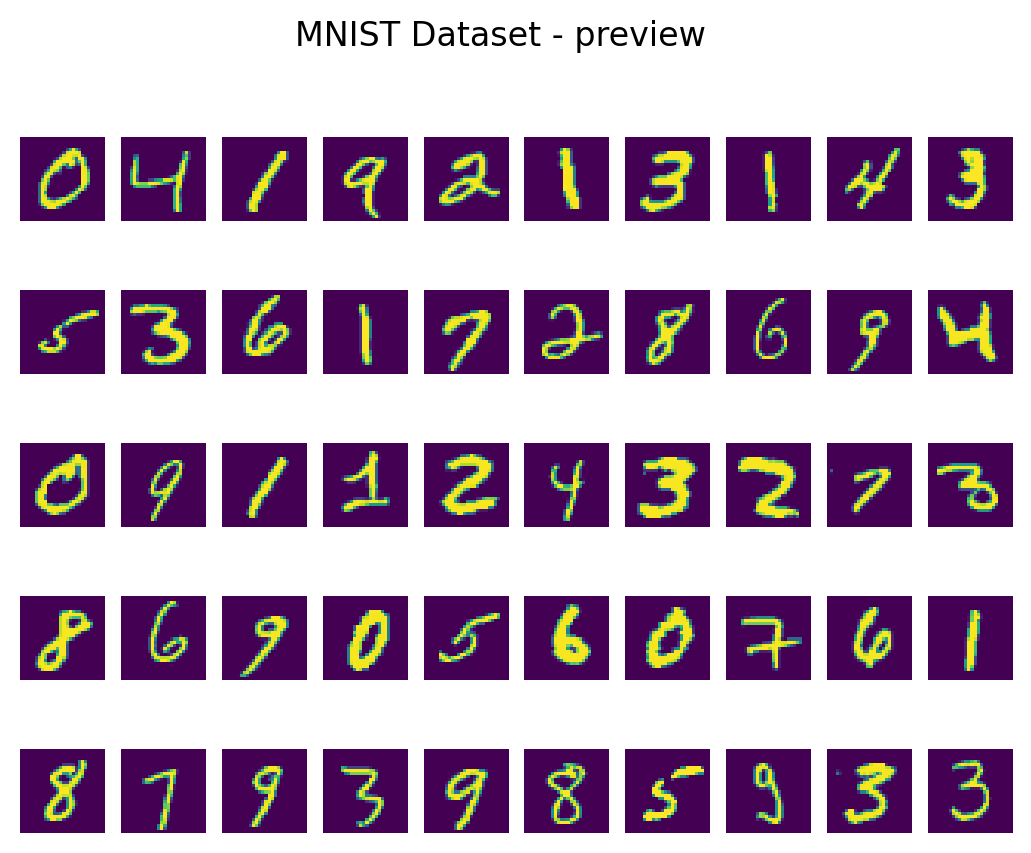

In [7]:
fig = plt.figure()
for index in range(1, ROW_IMG * N_ROWS + 1):
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis('off')
    plt.imshow(train_dataset.data[index])
    #plt.imshow(train_dataset.data[index], cmap='gray_r')
fig.suptitle('MNIST Dataset - preview');

In [8]:
class LeNet5_ReLU(nn.Module):

    def __init__(self, n_classes):
        super(LeNet5_ReLU, self).__init__()

        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.ReLU()
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.ReLU(),
            nn.Linear(in_features=84, out_features=n_classes),
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1)
        return logits, probs

16:01:44 --- Epoch: 0	Train loss: 0.2444	Valid loss: 0.0887	Train accuracy: 96.91	Valid accuracy: 97.23
16:02:17 --- Epoch: 1	Train loss: 0.0795	Valid loss: 0.0602	Train accuracy: 98.30	Valid accuracy: 98.06
16:02:49 --- Epoch: 2	Train loss: 0.0551	Valid loss: 0.0488	Train accuracy: 98.72	Valid accuracy: 98.51
16:03:23 --- Epoch: 3	Train loss: 0.0441	Valid loss: 0.0364	Train accuracy: 99.19	Valid accuracy: 98.79
16:03:58 --- Epoch: 4	Train loss: 0.0344	Valid loss: 0.0423	Train accuracy: 99.14	Valid accuracy: 98.61
16:04:35 --- Epoch: 5	Train loss: 0.0283	Valid loss: 0.0381	Train accuracy: 99.39	Valid accuracy: 98.94
16:05:07 --- Epoch: 6	Train loss: 0.0241	Valid loss: 0.0317	Train accuracy: 99.54	Valid accuracy: 99.02
16:05:37 --- Epoch: 7	Train loss: 0.0211	Valid loss: 0.0329	Train accuracy: 99.46	Valid accuracy: 98.89
16:06:07 --- Epoch: 8	Train loss: 0.0185	Valid loss: 0.0328	Train accuracy: 99.57	Valid accuracy: 99.05
16:06:38 --- Epoch: 9	Train loss: 0.0152	Valid loss: 0.0371	Trai

C:\Users\Ivan\AppData\Local\Temp\ipykernel_25912\1497479929.py:30: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')
C:\Users\Ivan\AppData\Local\Temp\ipykernel_25912\1497479929.py:43: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


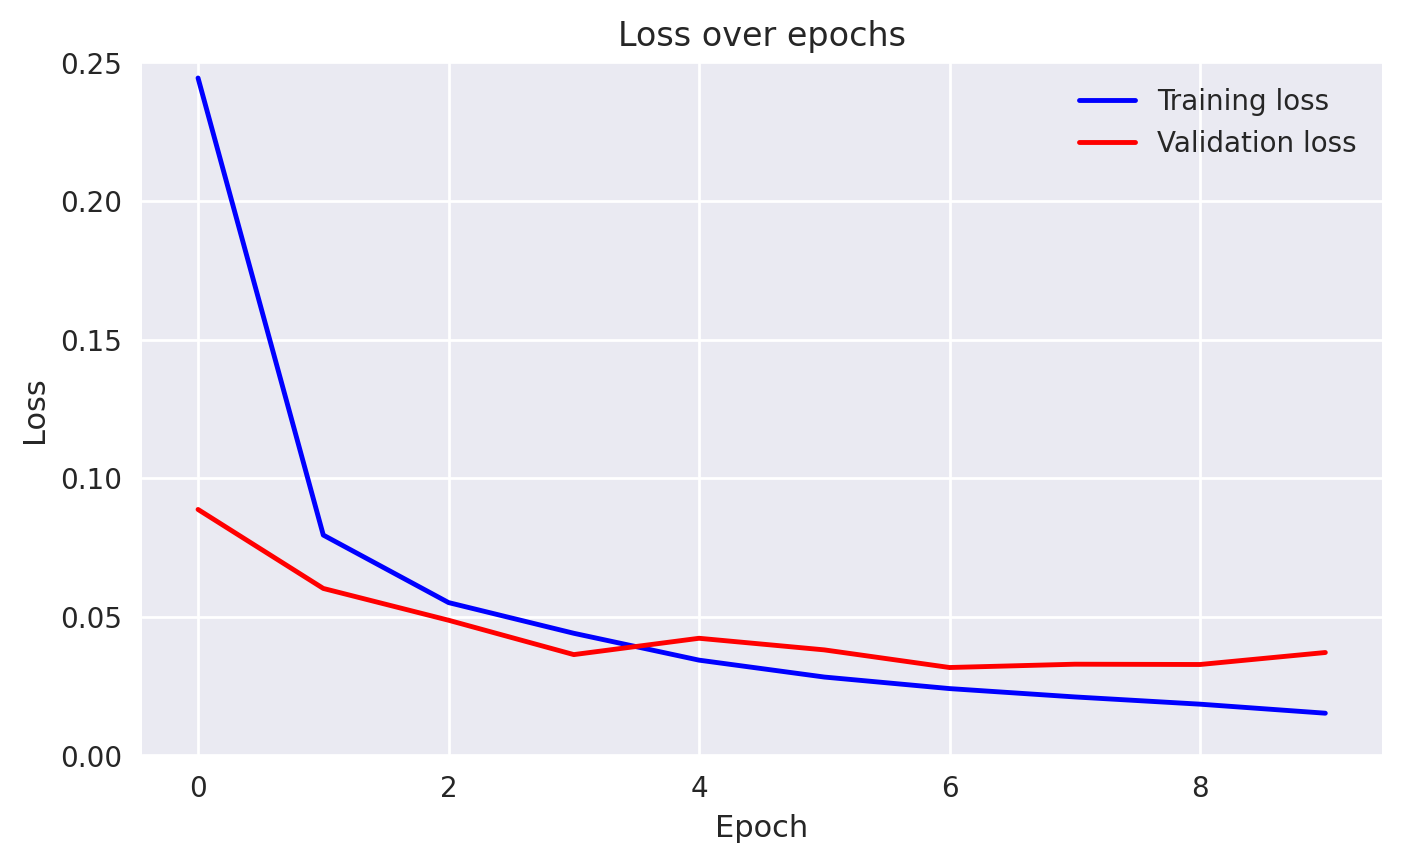

In [9]:
torch.manual_seed(RANDOM_SEED)

model_ReLU = LeNet5_ReLU(N_CLASSES).to(DEVICE)
optimizer_ReLU = torch.optim.Adam(model_ReLU.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()
model_ReLU, optimizer_ReLU, losses = training_loop(model_ReLU, criterion, optimizer_ReLU, train_loader, valid_loader, 10, DEVICE)

In [10]:
outputs = {}
inputs = {}

def get_feature_extractor_input_output_from(layer):
    def hook(model, input, output):
        outputs["feature_extractor_" + str(layer)] = output.detach()
        inputs["feature_extractor_" + str(layer)] = input

    return hook

def get_classifier_input_output_from(layer):
    def hook(model, input, output):
        outputs["classifier_" + str(layer)] = output.detach()
        inputs["classifier_" + str(layer)] = input

    return hook

def register_layers_output(model):
    for i in range(len(model.feature_extractor)):
        model.feature_extractor[i].register_forward_hook(get_feature_extractor_input_output_from(i))

    for i in range(len(model.classifier)):
        model.classifier[i].register_forward_hook(get_classifier_input_output_from(i))

register_layers_output(model_ReLU)

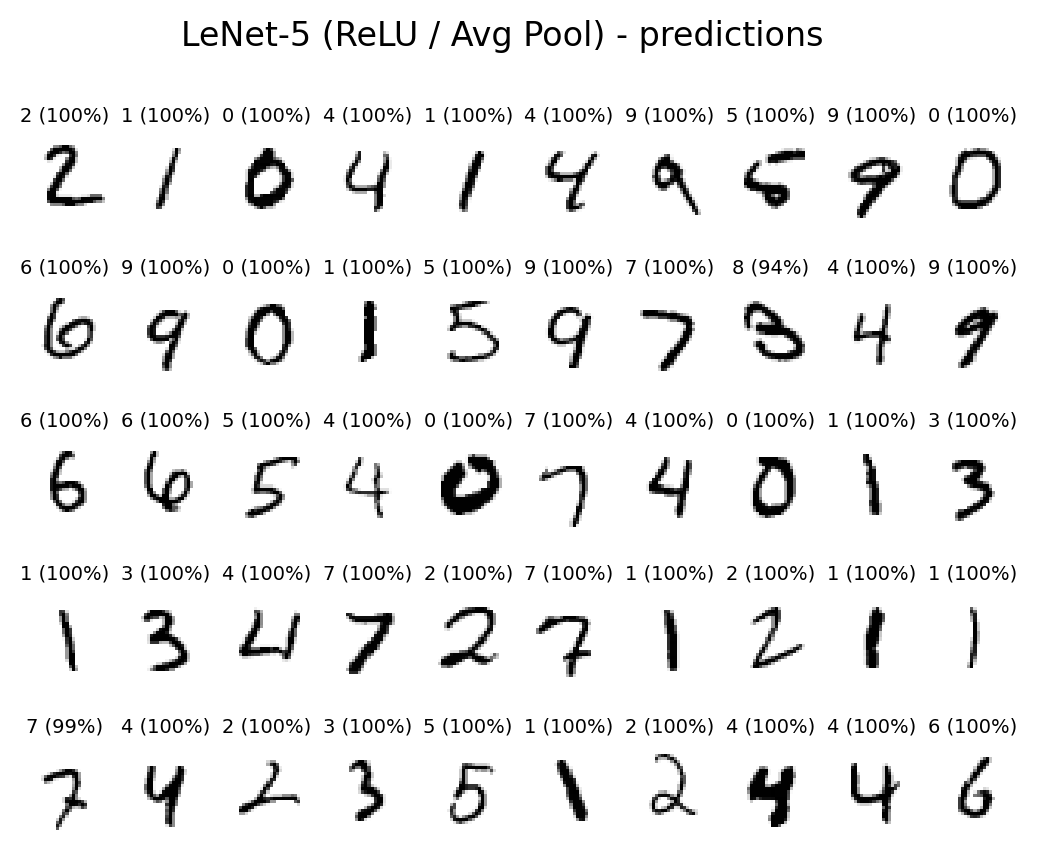

In [11]:
ROW_IMG = 10
N_ROWS = 5

fig = plt.figure()

executions = {"inputs": [], "outputs": []}

for index in range(1, ROW_IMG * N_ROWS + 1):
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis('off')
    plt.imshow(valid_dataset.data[index], cmap='gray_r')

    with torch.no_grad():
        model_ReLU.eval()
        _, probs = model_ReLU(valid_dataset[index][0].unsqueeze(0).to(DEVICE))

    executions["inputs"].append(inputs)
    executions["outputs"].append(outputs)
    inputs = {}
    outputs = {}

    title = f'{torch.argmax(probs)} ({torch.max(probs * 100):.0f}%)'

    plt.title(title, fontsize=7)
    fig.suptitle('LeNet-5 (ReLU / Avg Pool) - predictions');

In [12]:
def create_if_not_exists(base_path):
    try:
        os.makedirs(base_path)
    except FileExistsError:
        pass

def extract_layer_number_from(param_name):
    return param_name.split('.')[1]


def extract_param_type_from(param_name):
    return param_name.split('.')[2]


def write_tensor_to_file(tensor, file_path):
    text_file = open(file_path, "w+")
    tensor.data.numpy().tofile(text_file, sep=" ", format="%.8f")
    text_file.close()


def print_parameters(model):
    for name, param in model.named_parameters():
        if 'feature_extractor' in name:
            print(f"Feature_extractor Layer {extract_layer_number_from(name)} {extract_param_type_from(name)}")
        else:
            print(f" Classifier Layer {extract_layer_number_from(name)} {extract_param_type_from(name)}")
        print(f"Shape: {list(param.size())}")
        print(param.data)
        print("---------------------------------------------------------------------------")


def write_parameters_to_file(model, path):
    create_if_not_exists(path)
    for name, param in model.named_parameters():
        filename = path + "P0-" + name + ".txt"
        write_tensor_to_file(param.cpu(), filename)



In [13]:
class bcolors:
    HEADER = '\033[95m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'

def print_intermediate_layers_for(execution):
    for key, val in execution.items():
        print("-------------------------")
        print(key)
        print("-------------------------")
        print(val)

def print_intermediate_layers_for_all(executions):
    print("Total executions " + str(len(executions)))
    for i in range(len(executions)):
        print("\n\n\nExecution " + str(i))
        print_intermediate_layers_for(executions[i])

def write_intermediate_layers_output_for(execution, base_path):
    create_if_not_exists(base_path)

    for key, val in execution.items():
        file_path = base_path + "P0-" + key + ".output.txt"
        write_tensor_to_file(val.cpu(), file_path)

def write_intermediate_layers_output_for_all(executions):
    for i in range(len(executions)):
        base_path = "LenetData/Outputs/Execution_" + str(i) + "/"
        create_if_not_exists(base_path)
        write_intermediate_layers_output_for(executions[i], base_path)

def write_intermediate_layers_input_for(execution, base_path):
    create_if_not_exists(base_path)

    for key, val in execution.items():
        file_path = base_path + "P0-" + key + ".input.txt"
        write_tensor_to_file(val[0].cpu(), file_path)

def write_intermediate_layers_input_for_all(executions):
    for i in range(len(executions)):
        base_path = "LenetData/Inputs/Execution_" + str(i) + "/"
        create_if_not_exists(base_path)
        write_intermediate_layers_input_for(executions[i], base_path)

def has_elements_bigger_than(items, max_value):
    layers =  list(items)
    last_layer_value = layers[-1][1]
    out_of_range_elements = last_layer_value[last_layer_value > max_value]
    return out_of_range_elements.size(dim=0) > 0

def has_elements_smaller_than(items, min_value):
    print(len(items))
    layers =  list(items)
    last_layer_value = layers[-1][1]
    out_of_range_elements = last_layer_value[last_layer_value < min_value]
    return out_of_range_elements.size(dim=0) < 0

def verify_elements_are_in_range(execution, max_value, min_value):
    if has_elements_bigger_than(execution.items(), max_value) and has_elements_smaller_than(execution.items(), min_value):
        print(bcolors.WARNING + "Warning: There are some elements out of range" + bcolors.ENDC)
    else:
        print(bcolors.OKGREEN + "All elements are in the desired range" + bcolors.ENDC)

def verify_all_executions_last_layer_output(max_value, min_value):

    for i in range(len(executions["outputs"])):
        current_execution = executions["outputs"][i]
        execution_name = f"Execution {str(i)}"
        print("-------------------------------------------------------------")
        print(execution_name)
        verify_elements_are_in_range(current_execution, max_value, min_value)

print("=============================================== Inputs ===============================================")
print_intermediate_layers_for_all(executions["inputs"])
print("=============================================== Outputs ===============================================")
print_intermediate_layers_for_all(executions["outputs"])
verify_all_executions_last_layer_output(max_value = 14, min_value= -14)
write_intermediate_layers_input_for_all(executions["inputs"])
write_intermediate_layers_output_for_all(executions["outputs"])


=============================================== Inputs ===============================================
Total executions 50



Execution 0
-------------------------
feature_extractor_0
-------------------------
(tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]], device='cuda:0'),)
-------------------------
feature_extractor_1
-------------------------
(tensor([[[[-0.0249, -0.0249, -0.0249,  ..., -0.0249, -0.0249, -0.0249],
          [-0.0249, -0.0249, -0.0249,  ..., -0.0249, -0.0249, -0.0249],
          [-0.0249, -0.0249, -0.0249,  ..., -0.0249, -0.0249, -0.0249],
          ...,
          [-0.0249, -0.0249, -0.0249,  ...,  0.0013, -0.0003,  0.0006],
          [-0.0249, -0.0249, -0.0249,  ..., -0.0249, -0.0249, -0.0249],
          [-0.0249, -0.0249, -0.0249,  ..., -0.0249,

In [14]:
print_parameters(model_ReLU)
path = "LenetData/Parameters/Default-parameters/"
write_parameters_to_file(model_ReLU, path)

Feature_extractor Layer 0 weight
Shape: [6, 1, 5, 5]
tensor([[[[ 0.1381,  0.1629, -0.0721,  0.0689, -0.2869],
          [ 0.0945,  0.1000,  0.3527,  0.3104, -0.2287],
          [ 0.1901,  0.2375,  0.4196,  0.2381,  0.1101],
          [-0.1849,  0.1236,  0.0620, -0.0595, -0.0150],
          [-0.4137, -0.2598, -0.2491,  0.0184, -0.2846]]],


        [[[-0.0548, -0.0993, -0.2263, -0.1772, -0.5631],
          [ 0.1251, -0.1543,  0.2176,  0.0176, -0.3534],
          [ 0.1052,  0.2421,  0.5074,  0.2872, -0.1308],
          [ 0.0379,  0.2010,  0.4533,  0.4698,  0.1608],
          [-0.2823,  0.1046,  0.0684,  0.1423, -0.1238]]],


        [[[-0.3164, -0.1526, -0.1699,  0.1714,  0.0078],
          [-0.0058,  0.1940,  0.2497,  0.3809, -0.1403],
          [ 0.0322,  0.2064,  0.4945,  0.1524, -0.1060],
          [-0.0223,  0.4795,  0.1774, -0.1907, -0.5512],
          [ 0.0922,  0.1888,  0.2478, -0.4085, -0.6177]]],


        [[[-0.5228, -0.3821,  0.1341,  0.3202,  0.4429],
          [-0.4370, -0.

In [15]:
# train the model again only 1 time

dataset_batch_size_1 = [train_dataset[0]]
train_loader_size_1 = DataLoader(dataset=dataset_batch_size_1)

training_losses = losses[0]

new_train_model, new_train_optimizer, new_train_loss = train(train_loader_size_1, model_ReLU, criterion, optimizer_ReLU, DEVICE)
print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'initial loss: {training_losses[-1]:.20f}')
print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'loss: {new_train_loss:.20f}')

path = "LenetData/Parameters/Dataset-size-1-batch/"
write_parameters_to_file(new_train_model, path)

16:06:50 --- initial loss: 0.01523819272645365874
16:06:50 --- loss: 0.00287690781988203526


In [16]:
new_train_model.classifier[0].weight.grad


tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000, -0.0018,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='cuda:0')